# Clustering
在“无监督学习”（unsupervised learning）中，训练样本的标记信息是未知的，目标是通过对无标记训练样本的学习来揭示数据的内在性质及规律，为进一步的数据分析提供基础。在本次实验中，我们将首先生成数据集，并实现一个K-means算法和GMM算法来对生成的数据集进行聚类。

## 生成数据集

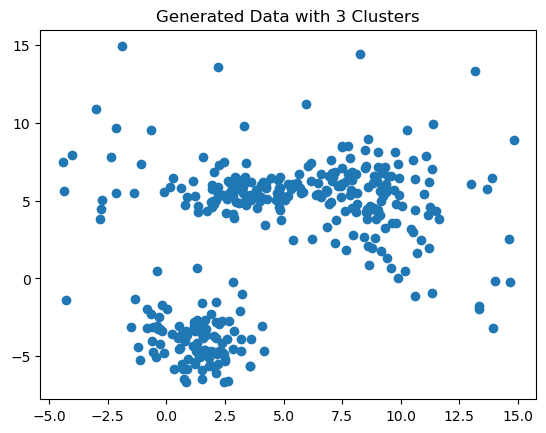

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_covariance(n_features, scale=1.0):
    """
    Generates a random positive-definite covariance matrix for a given number of features.
    
    Args:
        n_features (int): The number of features.
        scale (float): A scaling factor to control the size of the covariance.
    
    Returns:
        numpy.ndarray: A positive-definite covariance matrix.
    """
    # Generate a random matrix and make it symmetric to ensure positive definiteness
    A = np.random.randn(n_features, n_features)
    cov_matrix = np.dot(A, A.T)  # This ensures it's positive-definite
    cov_matrix += np.eye(n_features) * scale  # Add a small identity matrix to ensure it's well-conditioned
    return cov_matrix

def data_generator(n_clusters, n_samples_per_cluster, n_features=2,
                   background_noise_range=None, background_noise_num=0):
    """
    Generates a synthetic dataset for clustering using a multivariate normal distribution.
    
    Args:
        n_clusters (int): The number of clusters (Gaussian components).
        n_samples_per_cluster (int): The number of samples to generate per cluster.
        n_features (int): The number of features for each sample (default is 2).
        background_noise_range (tuple or None): A tuple defining the range for background noise points, 
                                                 if None, no noise is added.
        background_noise_num (int): Number of background noise points to generate.
        
    Returns:
        numpy.ndarray: Generated data with shape (n_samples, n_features).
    """
    
    # Initialize lists to hold the data
    data = []
    
    # Generate random cluster means
    cluster_means = np.random.uniform(low=-10, high=10, size=(n_clusters, n_features))
    
    # Generate random covariance matrices for each cluster
    cluster_covariances = [generate_random_covariance(n_features) for _ in range(n_clusters)]
    
    # Generate data for each cluster
    for i in range(n_clusters):
        cluster_data = np.random.multivariate_normal(cluster_means[i], cluster_covariances[i], n_samples_per_cluster)
        data.append(cluster_data)
    
    # Combine all clusters into a single dataset
    data = np.vstack(data)
    
    # Add background noise if specified
    if background_noise_range is not None and background_noise_num > 0:
        noise = np.random.uniform(background_noise_range[0], background_noise_range[1], size=(background_noise_num, n_features))
        data = np.vstack([data, noise])
    
    # Shuffle the data (optional)
    np.random.shuffle(data)
    
    return data

# Example usage:
n_clusters = 3
n_samples_per_cluster = 100
n_features = 2

# Generate the data
X = data_generator(n_clusters=n_clusters, 
                   n_samples_per_cluster=n_samples_per_cluster, 
                   n_features=n_features, 
                   background_noise_range=[[-5, -5], [15, 15]], 
                   background_noise_num=50)

# Plot the generated data
plt.scatter(X[:, 0], X[:, 1])
plt.title(f"Generated Data with {n_clusters} Clusters")
plt.show()


## 数据归一化
必须对数据进行归一化，以防止数值较高的特征比其他特征贡献得更多。在实际应用中，我们将按照以下步骤对数据进行标准化处理。


In [4]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

## 一、K-Means Clustering
K-means 算法是一种迭代方法，它试图将数据集划分为 $K$ 个预定义的聚类，每个数据点只属于一个聚类。
            
该算法的工作流程如下:
- 指定聚类数目 $K$
- 随机在空间中为每个聚类初始化一个中心
- 对于每个数据点，计算该点与每个中心之间的欧氏距离，并采用最近邻分类器将该点分配给最近的中心
- 根据每个聚类中包含的点重新计算中心的位置，并重复上述步骤，直到中心不再发生变化

K-means 解决问题的方式被称为 期望最大化（Expectation-Maximization, EM）。E 步骤将每个数据点分配给一个聚类，而 M 步骤则根据每个聚类内的点来更新质心的值。

对应的目标函数为:
$$
    \large J = \sum_{i=1}^{m} \sum_{k=1}^{K} I(z_i = k)||x_i - \mu_k||_2^2
$$
这里$I(\cdot)$表示为前面讲过的指示函数(indicator function),  $z_i$ 是分配给数据点 $x_i$ 的聚类编号(课件上用的是$y^{(i)}$)，$\mu_k$ 是聚类 $k$ 的质心。

E步骤定义为：
$$
    \large z_i^{*} = \text{argmin}_{k} ||x_i - \mu_k||_2^2
$$

M步骤定义为：
$$
    \large \mu_k = \frac{1}{\sum_{i=1}^m I (z_i = k)} \sum_{i=1}^m  x_i I(z_i = k)
$$

在实际应用中，我们应该多次运行K−means算法，使用不同的中心初始化，并保留那些能够最小化目标函数的参数。由于K−means是基于距离的算法，因此必须对数据进行标准化

In [6]:
class KMeansClustering():
    """K-Means class implemented in NumPy"""

    def __init__(self, n_clusters=5):
        """Inits KMeansClustering class setting the number of clusters"""
        self.n_clusters = n_clusters
        self.centroids = None
        
    def fit_predict(self, X, n_iter=20):
        """Trains the KMeans and clusterizes the input data"""
        size = X.shape[0]
        n_features = X.shape[1]
        
        # Initialize distance matrix and labels
        dists = np.zeros((size, self.n_clusters))
        best_loss = 1e10
        pred = None
        
        for _ in range(n_iter):
            # Randomly initialize centroids using k-means++ initialization
            centroids = self._initialize_centroids(X)
            old_loss = -1
            
            while True:
                ### START CODE HERE ###
                # E-step: assign each point to the nearest centroid
                for i in range(self.n_clusters):
                    dists[:, i] = np.linalg.norm(X - centroids[:, i], axis=1)   # 求取每个点到centroids的距离，             

                dists_min = np.min(dists, axis=1)  # 选取最短的作为归属点
                labels = np.argmin(dists, axis=1)  # tips：np.argmin()可以返回距离最近的点对应的下标
                ### END CODE HERE ###
                
                ### START CODE HERE ###
                # M-step: recompute the centroids
                for i in range(self.n_clusters):
                    idx = np.where(labels == i)[0]
                    if len(idx) > 0:
                        centroids[:, i] = np.mean(X[idx], axis=0)  # 更新每个 centroids
                ### END CODE HERE ###
                 
                # Calculate loss (sum of distances between points and their centroids)
                new_loss = dists_min.sum()
                if old_loss == new_loss:
                    break
                old_loss = new_loss
                
            # Keep track of the best solution
            if new_loss < best_loss:
                best_loss = new_loss
                pred = labels
        
        return pred
    
    def _initialize_centroids(self, X):
        """Initialize centroids using k-means++"""
        n_samples, n_features = X.shape
        centroids = np.zeros((n_features, self.n_clusters))
        
        # Choose the first centroid randomly
        centroids[:, 0] = X[np.random.randint(0, n_samples)]
        
        # Choose the remaining centroids
        for i in range(1, self.n_clusters):
            # Calculate the distances from all points to the closest centroid
            distances = np.zeros(n_samples)
            for j in range(n_samples):
                # Calculate distance from the j-th sample to all existing centroids
                # Reshape X[j] to (1, n_features) so it can be broadcast with centroids[:, :i]
                dist_to_centroids = np.linalg.norm(X[j] - centroids[:, :i].T, axis=1)
                distances[j] = np.min(dist_to_centroids)  # Find the min distance to the closest centroid
            
            # Probability distribution based on distances
            prob = distances / distances.sum()
            cumulative_prob = np.cumsum(prob)
            r = np.random.rand()
            centroid_idx = np.searchsorted(cumulative_prob, r)
            centroids[:, i] = X[centroid_idx]
        
        return centroids

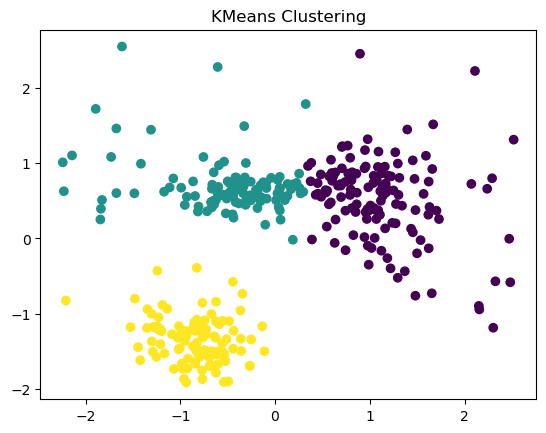

In [7]:
# Fit KMeans and predict clusters
kms = KMeansClustering(n_clusters=3)
pred = kms.fit_predict(X)

# Plot the clustering result
plt.scatter(X[:, 0], X[:, 1], c=pred, cmap='viridis')
plt.title("KMeans Clustering")
plt.show()

### Gaussian Mixture Model (GMM)
为了理解如何训练一个高斯混合模型，首先必须解释期望最大化（EM）算法。EM算法是一种用于求解含有潜在变量的概率模型最大似然估计（MLE）问题的通用技术，它从一个初始的概率模型参数估计$\boldsymbol{\theta}$ 开始，然后通过不断更新参数 $\boldsymbol{\theta}$ ，直到收敛。该算法由期望步骤（E步）和最大化步骤（M步）交替执行。

我们来考虑一个具有 $K$ 个混合成分的多变量高斯混合模型，其中观察变量为 $\boldsymbol{X}$，潜在变量为 $\boldsymbol{Z}$，$\boldsymbol{\theta}=\{\alpha_k, \mu_k, \Sigma_k\}_{k=1}^K$, 其模型如下：

$$
\large
\begin{aligned}
    p(\boldsymbol{x}_i; \boldsymbol{\theta}) &= \sum_{k=1}^{K} \alpha_k p(\boldsymbol{x}_i | \boldsymbol{z}_i; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)\\
    &= \sum_{k=1}^{K} P(\boldsymbol{z}_i = k) \mathcal{N}(\boldsymbol{x}_i; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
\end{aligned}
$$
其中，混合模型的每个成分都是一个正态分布$p(\boldsymbol{x}; \boldsymbol{\mu}, \boldsymbol{\Sigma})$。接下来我们来看看为什么高斯混合模型的最大似然估计（MLE）计算起来很困难。高斯混合分布的似然函数为：
$$
\large
    L(\boldsymbol{\theta} | \boldsymbol{X}) = \prod_{i=1}^m\sum_{k=1}^{K} \alpha_k p(\boldsymbol{x}_i; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$

对应的对数似然函数为：
$$
\large
    \mathcal{L}(\boldsymbol{\theta} | \boldsymbol{X}) = \sum_{i=1}^m \log\left(\sum_{k=1}^{K} \alpha_k p(\boldsymbol{x}_i; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)\right)
$$

由于对数内部有一个求和，显然无法在不知道 $\boldsymbol{Z}$ 的情况下来估计出 $\boldsymbol{\mu}_k$ 和 $\boldsymbol{\Sigma}_k$。因此必须使用 EM 算法进行优化求解。

EM 算法包含期望步骤（E步）和最大化步骤（M步）两个步骤。E步将每个数据点分配给每个混合成分的概率，而 M步则根据 E步中估计的值，重新评估每个混合成分的参数。在 E 步骤中，我们使用估计的参数来计算每个数据点的似然度：

$$
\large
    p(\boldsymbol{x_i}; \mu_k, \boldsymbol{\Sigma}_k) = \frac{1}{\sqrt{(2\alpha)^n|\boldsymbol{\Sigma}_k|}} \exp\left(-\frac{(\boldsymbol{x}_i - \boldsymbol{\mu}_k)^\top \boldsymbol{\Sigma}_k^{-1}(\boldsymbol{x}_i - \boldsymbol{\mu}_k)}{2}\right)
$$
其中，$n$ 是输入数据的特征数。

可以计算数据点 $\boldsymbol{x}_i$ 来自第 $k$ 个高斯分布的概率： 
$$
\Large
    \gamma_{ik} = \frac{\alpha_k p(\boldsymbol{x_i}; \mu_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^{K} \alpha_j p(\boldsymbol{x_i}; \mu_j, \boldsymbol{\Sigma}_j)}
$$

对于 M 步骤，我们更新混合模型的参数如下：
$$
\Large
\begin{aligned}
    \alpha_k &= \frac{1}{N}\sum_{i=1}^{m} p_{ik}\\
    \boldsymbol{\mu}_k &= \frac{1}{\sum_{i=1}^{m} p_{ik}} \sum_{i=1}^{N} p_{ik} \boldsymbol{x_i}\\
    \boldsymbol{\Sigma}_k &= \frac{1}{\sum_{i=1}^{m} p_{ik}} \sum_{i=1}^{N} p_{ik} (\boldsymbol{x}_i - \boldsymbol{\mu}_k) (\boldsymbol{x}_i - \boldsymbol{\mu}_k)^\top
\end{aligned}
$$

In [9]:
import math
class GaussianMixture:
    """Gaussian Mixture model class separating data into clusters."""
    
    def __init__(self, n_components, n_iter):
        """Initializes the GaussianMixture class with n_components and n_iter."""
        self.n_components = n_components
        self.n_iter = n_iter
        
    def gaussian_likelihood(self, X, n):
        """Returns the Gaussian likelihood of X from the nth Gaussian."""
        ### START CODE HERE ###
        mu = self.mu[n]
        sigma = self.sigma[n]
        det = np.linalg.det(sigma)
        inv_sigma = np.linalg.inv(sigma)
        diff = X - mu
        exponent = -0.5 * np.einsum('ij,jk,ik->i', diff, inv_sigma, diff)
        prob = (1 / np.sqrt((2 * np.pi)**self.n_features * det)) * np.exp(exponent)
    
        ### END CODE HERE ###
      
        return prob
        
    def e_step(self, X):
        """Assigns to each data point the probability of belonging to each Gaussian."""
        ### START CODE HERE ###       
        self.likelihoods = np.zeros((self.n_samples, self.n_components))
        for j in range(self.n_components):
            self.likelihoods[:, j] = self.gaussian_likelihood(X, j)
        
        # Compute the probabilities of each sample belonging to each Gaussian
        weighted_likelihoods = self.likelihoods * self.priors
        self.probs = weighted_likelihoods / np.sum(weighted_likelihoods, axis=1, keepdims=True)
        ### END CODE HERE ###

   
    def m_step(self, X):
        """Recomputes the parameters (mu, sigma, priors) of each Gaussian component."""
        for j in range(self.n_components):
        ### START CODE HERE ###         
            probs_j = self.probs[:, j]  # Probabilities for the j-th Gaussian
            probs_j_sum = np.sum(probs_j)
            self.priors[j] = probs_j_sum / self.n_samples
         
            # Recompute the mean of each Gaussian
            self.mu[j] = np.sum(X * probs_j[:, np.newaxis], axis=0) / probs_j_sum
            
            # Recompute the covariance matrix of each Gaussian
            X_minus_mu = X - self.mu[j]
            self.sigma[j] = np.dot((X_minus_mu * probs_j[:, np.newaxis]).T, X_minus_mu) / probs_j_sum
        ### END CODE HERE ###
    
                    
    def fit_predict(self, X):
        """Trains the model and returns the clusters."""
        self.n_samples, self.n_features = X.shape
        
        # Initialize the covariance matrices and means of the Gaussians
        self.sigma = np.zeros((self.n_components, self.n_features, self.n_features))
        self.mu = np.zeros((self.n_components, self.n_features))
        self.priors = np.ones(self.n_components) / self.n_components
        
        # Use KMeans to initialize the probabilities of each sample belonging to each Gaussian
        kmeans = KMeansClustering(n_clusters=self.n_components)
        pred = kmeans.fit_predict(X)
        self.probs = np.zeros((self.n_samples, self.n_components))
        for i in range(self.n_samples):
            self.probs[i, pred[i]] = 1
        
        # Set the covariance parameter of each component to the covariance of the data
        X_centered = X - X.mean(axis=0)
        X_cov = np.cov(X_centered, rowvar=False)
        for j in range(self.n_components):
            self.sigma[j] = X_cov
            # Select a random sample as the mean of each Gaussian
            self.mu[j] = X[np.random.choice(self.n_samples)]
        
        self.likelihoods = np.zeros((self.n_samples, self.n_components))
        
        # Initialize the parameters based on KMeans and covariance of the data
        self.m_step(X)  # Initial M-step to compute the parameters
        for _ in range(self.n_iter):
            self.e_step(X)
            self.m_step(X)
            
        return np.argmax(self.probs, axis=1)


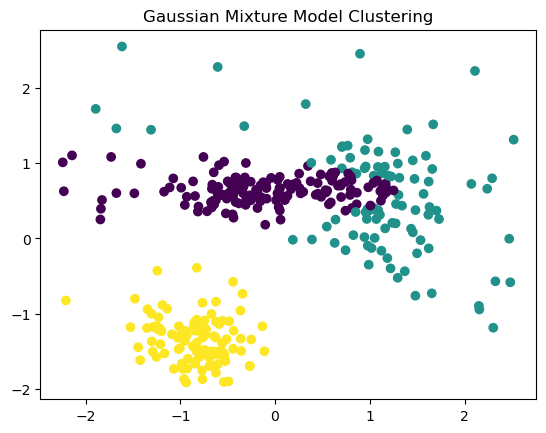

In [10]:
# Fit GMM and predict clusters
gmm = GaussianMixture(n_components=3, n_iter=10)
pred_gmm = gmm.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=pred_gmm, cmap='viridis')
plt.title("Gaussian Mixture Model Clustering")
plt.show()

可以将两者的结果对比来看

Text(0.5, 1.0, 'GMM clusters')

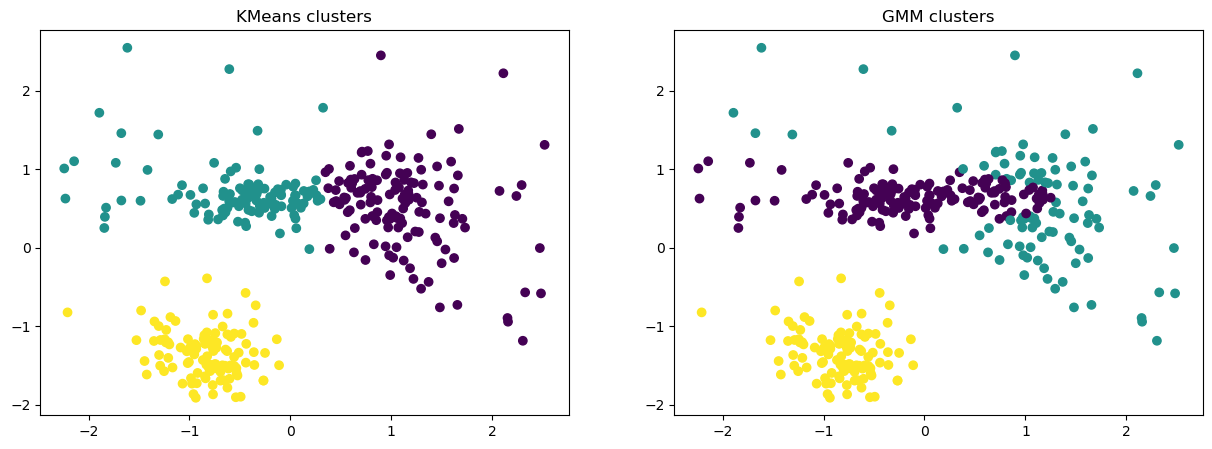

In [12]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.scatter(X[:, 0], X[:, 1], c=pred)
ax2.scatter(X[:, 0], X[:, 1], c=pred_gmm)
ax1.set_title('KMeans clusters')
ax2.set_title('GMM clusters')

### Conclusion
K-Means算法只能描述球形簇，而GMM可以表达椭圆形簇。在这个实验中，GMM可以找到我们生成的高斯分布。而K-Means虽然很好地分离了数据，但对于聚类椭圆形簇仍然缺乏表达能力。

K-Means比其他EM算法显著更快更简单，但对于具有不同大小和形状的簇的数据，GMM表现更好。